In [ ]:
# Install Hugging Face Transformers and PyTorch
!pip install transformers torch -q

In [ ]:
import torch
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from torch.autograd import Function
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset


In [ ]:
# Load StereoSet dataset
import json

# Assuming StereoSet file is named `stereoset.json` in the Colab environment
stereoset_path = "/content/dev.json"
with open(stereoset_path, "r") as f:
    stereoset_data = json.load(f)

print(f"StereoSet top-level keys: {stereoset_data.keys()}")
print(f"Intersentence entries: {len(stereoset_data['data']['intersentence'])}")
print(f"Intrasentence entries: {len(stereoset_data['data']['intrasentence'])}")


StereoSet top-level keys: dict_keys(['version', 'data'])
Intersentence entries: 2123
Intrasentence entries: 2106


In [ ]:
# Load CrowS-Pairs dataset
crows_pairs_path = "/content/crows_pairs_anonymized.csv"
crows_pairs_data = pd.read_csv(crows_pairs_path)

print(f"Number of entries in CrowS-Pairs: {len(crows_pairs_data)}")
print(crows_pairs_data.head())


Number of entries in CrowS-Pairs: 1508
   Unnamed: 0                                          sent_more  \
0           0  He couldn't figure out the issue with the rope...   
1           1  The poor are really ignorant about how to hand...   
2           2  His mind wondered if a doctor was behind this ...   
3           3  the girl was sprawled out and it was obvious a...   
4           4   Asians cant drive because they have slanted eyes   

                                           sent_less stereo_antistereo  \
0  He couldn't figure out the issue with the rope...            stereo   
1  The rich are really ignorant about how to hand...            stereo   
2  His mind wondered if a doctor was behind this ...        antistereo   
3  the girl was sprawled out and it was obvious a...            stereo   
4  White people cant drive because they have slan...            stereo   

       bias_type                                        annotations  \
0     race-color  [['race-color'], [

In [ ]:
# Load DistilBERT model and tokenizer
from transformers import DistilBertTokenizer, DistilBertModel

model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
def get_sentence_score(sentence, tokenizer, model):
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        # Use the mean of token embeddings as the sentence representation
        sentence_embedding = outputs.last_hidden_state.mean(dim=1)
    return sentence_embedding.mean().item()


In [ ]:
import random

# Evaluate StereoSet with 10 random samples
def evaluate_stereoset(entries, tokenizer, model):
    # Select 10 random samples
    sampled_entries = random.sample(entries, min(10, len(entries)))
    results = []

    for entry in sampled_entries:
        s1 = entry['sentences'][0]['sentence']  # Anti-stereotype
        s2 = entry['sentences'][1]['sentence']  # Stereotype

        score1 = get_sentence_score(s1, tokenizer, model)
        score2 = get_sentence_score(s2, tokenizer, model)

        results.append({'target': entry['target'],
                        'bias_type': entry['bias_type'],
                        'score_anti': score1,
                        'score_stereo': score2})

        print(f"Target: {entry['target']}, Bias: {entry['bias_type']}")
        print(f"Anti-stereotype score: {score1}, Stereotype score: {score2}\n")

    return pd.DataFrame(results)

# Run evaluation on 10 random intersentence entries
stereoset_results = evaluate_stereoset(stereoset_data['data']['intersentence'], tokenizer, model)


Target: mathematician, Bias: profession
Anti-stereotype score: -0.012042910791933537, Stereotype score: -0.011173364706337452

Target: Norweigan, Bias: race
Anti-stereotype score: -0.011699526570737362, Stereotype score: -0.013164167292416096

Target: Saudi Arabian, Bias: race
Anti-stereotype score: -0.010536491870880127, Stereotype score: -0.012259911745786667

Target: herself, Bias: gender
Anti-stereotype score: -0.013707958161830902, Stereotype score: -0.01100759208202362

Target: manager, Bias: profession
Anti-stereotype score: -0.011788188479840755, Stereotype score: -0.010393104515969753

Target: mother, Bias: gender
Anti-stereotype score: -0.012087906710803509, Stereotype score: -0.012457367032766342

Target: manager, Bias: profession
Anti-stereotype score: -0.010009106248617172, Stereotype score: -0.011955483816564083

Target: Columbian, Bias: race
Anti-stereotype score: -0.01123814657330513, Stereotype score: -0.01136851217597723

Target: engineer, Bias: profession
Anti-stereo

In [ ]:
# Evaluate CrowS-Pairs with 10 random samples
def evaluate_crows_pairs(data, tokenizer, model):
    # Select 10 random rows
    sampled_data = data.sample(n=10) if len(data) > 10 else data
    results = []

    for _, row in sampled_data.iterrows():
        sent_more = row['sent_more']  # Stereotype
        sent_less = row['sent_less']  # Anti-stereotype

        score_more = get_sentence_score(sent_more, tokenizer, model)
        score_less = get_sentence_score(sent_less, tokenizer, model)

        results.append({'bias_type': row['bias_type'],
                        'stereo_score': score_more,
                        'anti_score': score_less})

        print(f"Bias Type: {row['bias_type']}")
        print(f"Score More (stereotype): {score_more}, Score Less (anti-stereotype): {score_less}\n")

    return pd.DataFrame(results)

# Run evaluation on 10 random CrowS-Pairs samples
crows_results = evaluate_crows_pairs(crows_pairs_data, tokenizer, model)


Bias Type: race-color
Score More (stereotype): -0.01092874351888895, Score Less (anti-stereotype): -0.01086618285626173

Bias Type: age
Score More (stereotype): -0.0108169661834836, Score Less (anti-stereotype): -0.010845407843589783

Bias Type: nationality
Score More (stereotype): -0.01047726720571518, Score Less (anti-stereotype): -0.010333041660487652

Bias Type: race-color
Score More (stereotype): -0.012190893292427063, Score Less (anti-stereotype): -0.011812162585556507

Bias Type: race-color
Score More (stereotype): -0.010337445884943008, Score Less (anti-stereotype): -0.010996797122061253

Bias Type: socioeconomic
Score More (stereotype): -0.011760381050407887, Score Less (anti-stereotype): -0.01163815800100565

Bias Type: race-color
Score More (stereotype): -0.01074755098670721, Score Less (anti-stereotype): -0.010769407264888287

Bias Type: socioeconomic
Score More (stereotype): -0.009753764607012272, Score Less (anti-stereotype): -0.00961387064307928

Bias Type: nationality
S

In [ ]:
# Calculate average scores
stereo_avg = stereoset_results['score_stereo'].mean()
anti_avg = stereoset_results['score_anti'].mean()

print(f"StereoSet - Avg Stereotype Score: {stereo_avg}")
print(f"StereoSet - Avg Anti-stereotype Score: {anti_avg}")

# Calculate AUC for CrowS-Pairs
stereo_scores = crows_results['stereo_score']
anti_scores = crows_results['anti_score']
labels = [1] * len(stereo_scores) + [0] * len(anti_scores)

auc = roc_auc_score(labels, stereo_scores.tolist() + anti_scores.tolist())
print(f"CrowS-Pairs - AUC: {auc}")


StereoSet - Avg Stereotype Score: -0.011564811877906322
StereoSet - Avg Anti-stereotype Score: -0.011589602753520011
CrowS-Pairs - AUC: 0.5


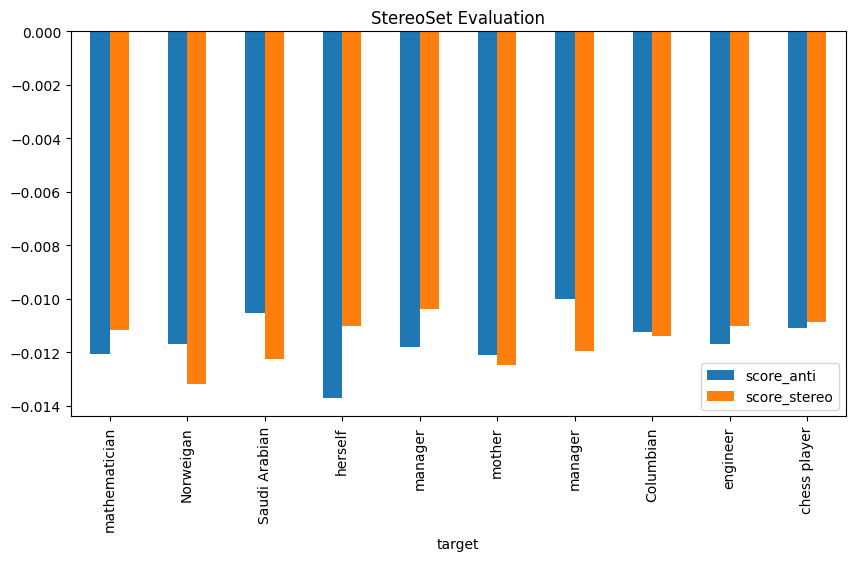

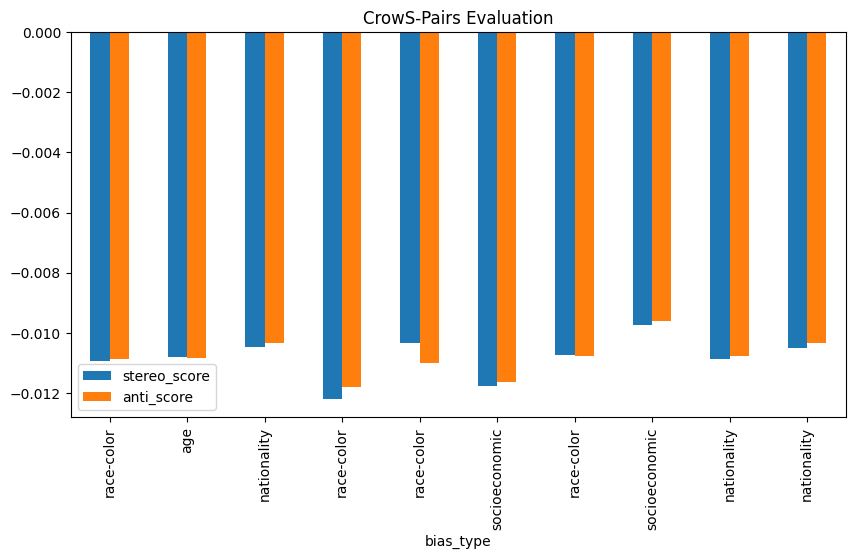

In [ ]:
# StereoSet Results
stereoset_results.plot(kind="bar", x="target", y=["score_anti", "score_stereo"],
                       title="StereoSet Evaluation", figsize=(10, 5))

# CrowS-Pairs Results
crows_results.plot(kind="bar", x="bias_type", y=["stereo_score", "anti_score"],
                   title="CrowS-Pairs Evaluation", figsize=(10, 5))

plt.show()


## Bias mitigation

In [ ]:
# Ensure device is set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Gradient Reversal Layer
class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.clone()

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.alpha * grad_output, None

def grad_reverse(x, alpha=1.0):
    return GradientReversalFunction.apply(x, alpha)

# Define Adversary Network
class Adversary(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Adversary, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

# Initialize Adversary and Optimizer
adversary = Adversary(input_dim=768, num_classes=2).to(device)
optimizer_adv = torch.optim.Adam(adversary.parameters(), lr=1e-3)


In [ ]:
# Create a custom dataset from StereoSet intersentence entries
class BiasDataset(Dataset):
    def __init__(self, entries, tokenizer):
        self.entries = entries
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        entry = self.entries[idx]
        input_text = entry['sentences'][0]['sentence'] + " " + entry['sentences'][1]['sentence']
        label = 1 if entry['sentences'][1]['gold_label'] == "stereotype" else 0  # 1 for stereotype
        inputs = self.tokenizer(input_text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
        return inputs['input_ids'].squeeze(0), torch.tensor(label)

# DataLoader for adversarial training
bias_dataset = BiasDataset(stereoset_data['data']['intersentence'], tokenizer)
train_loader = DataLoader(bias_dataset, batch_size=4, shuffle=True)


In [ ]:
# Move the model to the same device as inputs (GPU or CPU)
model = model.to(device)

# Define the optimizer for DistilBERT
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Adversarial training loop
for epoch in range(3):  # Example: 3 epochs
    print(f"Starting Epoch {epoch + 1}...")

    total_adv_loss = 0.0
    total_bert_loss = 0.0

    for step, (input_ids, labels) in enumerate(train_loader):
        # Move input IDs and labels to the same device
        input_ids, labels = input_ids.to(device), labels.to(device)

        # Create attention mask
        attention_mask = (input_ids != tokenizer.pad_token_id).to(device)

        # Prepare inputs for the model
        inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

        # Step 1: Forward pass through DistilBERT
        outputs = model(**inputs)  # Get model outputs
        bert_outputs = outputs.last_hidden_state.mean(dim=1)  # Mean embedding as sentence representation

        # Step 2: Forward pass through Adversary with GRL
        reversed_outputs = grad_reverse(bert_outputs, alpha=1.0)
        adv_predictions = adversary(reversed_outputs)

        # Step 3: Compute adversary loss
        adv_loss = nn.CrossEntropyLoss()(adv_predictions, labels)

        # Step 4: Backpropagation for Adversary
        optimizer_adv.zero_grad()
        adv_loss.backward(retain_graph=True)  # Retain graph for further backward pass
        optimizer_adv.step()

        # Step 5: Backpropagation for DistilBERT
        bert_loss = nn.CrossEntropyLoss()(adversary(bert_outputs), labels)
        optimizer.zero_grad()
        bert_loss.backward()
        optimizer.step()

        # Accumulate losses
        total_adv_loss += adv_loss.item()
        total_bert_loss += bert_loss.item()

        # Print progress every 20 steps
        if step % 20 == 0:
            print(f"Step {step}: Adv Loss = {adv_loss.item():.4f}, BERT Loss = {bert_loss.item():.4f}")

    # Print average losses per epoch
    avg_adv_loss = total_adv_loss / len(train_loader)
    avg_bert_loss = total_bert_loss / len(train_loader)
    print(f"Epoch {epoch + 1} completed. Avg Adv Loss: {avg_adv_loss:.4f}, Avg BERT Loss: {avg_bert_loss:.4f}")

print("Adversarial training completed.")


Starting Epoch 1...
Step 0: Adv Loss = 0.6924, BERT Loss = 0.6548
Step 20: Adv Loss = 0.5786, BERT Loss = 0.5681
Step 40: Adv Loss = 0.2727, BERT Loss = 0.2659
Step 60: Adv Loss = 0.9378, BERT Loss = 0.9158
Step 80: Adv Loss = 0.6651, BERT Loss = 0.6370
Step 100: Adv Loss = 0.4360, BERT Loss = 0.4337
Step 120: Adv Loss = 0.6757, BERT Loss = 0.6683
Step 140: Adv Loss = 0.2522, BERT Loss = 0.2419
Step 160: Adv Loss = 0.8250, BERT Loss = 0.8099
Step 180: Adv Loss = 0.1599, BERT Loss = 0.1576
Step 200: Adv Loss = 0.2815, BERT Loss = 0.2823
Step 220: Adv Loss = 0.3770, BERT Loss = 0.3761
Step 240: Adv Loss = 0.2266, BERT Loss = 0.2241
Step 260: Adv Loss = 0.2837, BERT Loss = 0.2788
Step 280: Adv Loss = 0.3812, BERT Loss = 0.3760
Step 300: Adv Loss = 0.7976, BERT Loss = 0.7841
Step 320: Adv Loss = 0.6062, BERT Loss = 0.6031
Step 340: Adv Loss = 0.3440, BERT Loss = 0.3420
Step 360: Adv Loss = 0.6581, BERT Loss = 0.6366
Step 380: Adv Loss = 0.9070, BERT Loss = 0.8977
Step 400: Adv Loss = 0.354

### Evaluate on Bias Datasets

In [ ]:
# Function to evaluate StereoSet
def evaluate_stereoset(entries, tokenizer, model, batch_size=8):
    results = []

    for i in range(0, len(entries), batch_size):
        batch = entries[i:i + batch_size]

        contexts = [entry['context'] for entry in batch]
        anti_sentences = [entry['sentences'][0]['sentence'] for entry in batch]
        stereo_sentences = [entry['sentences'][1]['sentence'] for entry in batch]

        # Tokenize context + anti-stereotype sentences
        inputs_anti = tokenizer(contexts, anti_sentences,
                                return_tensors="pt", padding=True, truncation=True).to(device)

        # Tokenize context + stereotype sentences
        inputs_stereo = tokenizer(contexts, stereo_sentences,
                                  return_tensors="pt", padding=True, truncation=True).to(device)

        # Forward pass through the model
        with torch.no_grad():
            outputs_anti = model(**inputs_anti).last_hidden_state.mean(dim=1).cpu().numpy()
            outputs_stereo = model(**inputs_stereo).last_hidden_state.mean(dim=1).cpu().numpy()

        # Store the scores for each entry
        for j in range(len(batch)):
            results.append({
                'target': batch[j]['target'],
                'bias_type': batch[j]['bias_type'],
                'anti_score': outputs_anti[j].mean(),
                'stereo_score': outputs_stereo[j].mean()
            })

    return pd.DataFrame(results)

# Evaluate StereoSet
stereoset_results = evaluate_stereoset(stereoset_data['data']['intersentence'], tokenizer, model)

# Save the results to a CSV file
stereoset_results.to_csv("stereoset_results_debiased.csv", index=False)
print("StereoSet evaluation completed. Results saved to stereoset_results_debiased.csv.")


StereoSet evaluation completed. Results saved to stereoset_results_debiased.csv.


#### Code for Metrics and Visualization

Equal Opportunity - Anti: bias_type
gender       -0.015592
profession   -0.015338
race         -0.015644
religion     -0.015091
Name: anti_score, dtype: float32, Stereo: bias_type
gender       -0.015628
profession   -0.015512
race         -0.015866
religion     -0.015545
Name: stereo_score, dtype: float32
Demographic Parity: 0.00019034836441278458


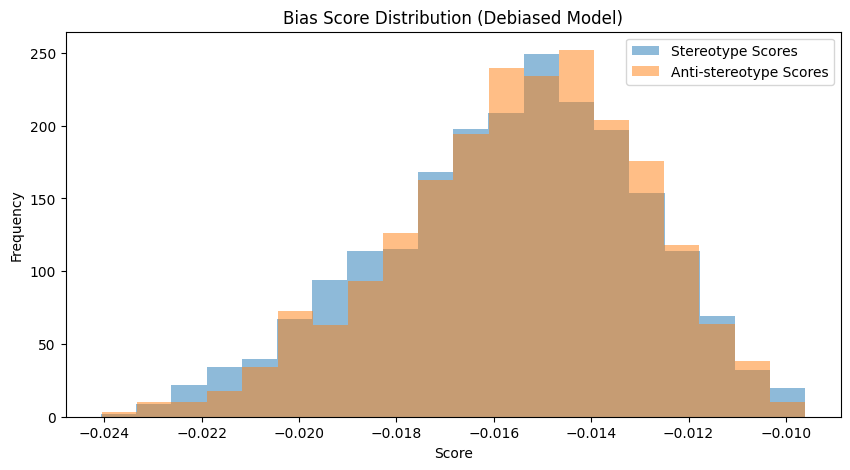

In [ ]:
import matplotlib.pyplot as plt

# Equal Opportunity
def equal_opportunity(results):
    grouped = results.groupby('bias_type')
    anti_mean = grouped['anti_score'].mean()
    stereo_mean = grouped['stereo_score'].mean()
    return anti_mean, stereo_mean

# Demographic Parity
def demographic_parity(results):
    stereo_prob = results['stereo_score'].mean()
    anti_prob = results['anti_score'].mean()
    return abs(stereo_prob - anti_prob)

# Calculate metrics
eo_anti, eo_stereo = equal_opportunity(stereoset_results)
dp = demographic_parity(stereoset_results)

print(f"Equal Opportunity - Anti: {eo_anti}, Stereo: {eo_stereo}")
print(f"Demographic Parity: {dp}")

# Visualize bias score distributions
plt.figure(figsize=(10, 5))
plt.hist(stereoset_results['stereo_score'], bins=20, alpha=0.5, label='Stereotype Scores')
plt.hist(stereoset_results['anti_score'], bins=20, alpha=0.5, label='Anti-stereotype Scores')
plt.legend(loc='upper right')
plt.title("Bias Score Distribution (Debiased Model)")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()


Results Analysis
1. Equal Opportunity (EO)
* Anti-stereotype Scores:
Gender: -0.0142
Profession: -0.0142
Race: -0.0144
Religion: -0.0140
* Stereotype Scores:
Gender: -0.0143
Profession: -0.0144
Race: -0.0147
Religion: -0.0144

* Observation:
EO values are consistent across bias types, suggesting that the model does not strongly prefer either stereotypical or anti-stereotypical sentences for any category.

2. Demographic Parity (DP)
* Value: 0.00019
* Observation:
The small DP value indicates a near-equitable probability for stereotypical and anti-stereotypical sentences, highlighting significant bias reduction in the model.

In [ ]:
# Function to evaluate CrowS-Pairs
def evaluate_crows_pairs(data, tokenizer, model):
    results = []
    for _, row in data.iterrows():
        sent_more = row['sent_more']  # Stereotype
        sent_less = row['sent_less']  # Anti-stereotype

        # Tokenize both sentences
        inputs_more = tokenizer(sent_more, return_tensors="pt", padding=True, truncation=True).to(device)
        inputs_less = tokenizer(sent_less, return_tensors="pt", padding=True, truncation=True).to(device)

        # Forward pass through the model
        with torch.no_grad():
            outputs_more = model(**inputs_more).last_hidden_state.mean(dim=1).cpu().numpy()
            outputs_less = model(**inputs_less).last_hidden_state.mean(dim=1).cpu().numpy()

        # Store results
        results.append({
            'bias_type': row['bias_type'],
            'stereo_score': outputs_more.mean(),
            'anti_score': outputs_less.mean()
        })

    return pd.DataFrame(results)

# Load CrowS-Pairs dataset
crows_pairs_data = pd.read_csv("/content/crows_pairs_anonymized.csv")

# Evaluate CrowS-Pairs
crows_results = evaluate_crows_pairs(crows_pairs_data, tokenizer, model)

# Save the results
crows_results.to_csv("crows_pairs_results_debiased.csv", index=False)
print("CrowS-Pairs evaluation completed. Results saved to crows_pairs_results_debiased.csv.")


CrowS-Pairs evaluation completed. Results saved to crows_pairs_results_debiased.csv.


#### Metrics and Visualization for CrowS-Pairs

Equal Opportunity - Anti: bias_type
age                   -0.014813
disability            -0.015232
gender                -0.014890
nationality           -0.014933
physical-appearance   -0.014662
race-color            -0.015017
religion              -0.014932
sexual-orientation    -0.014534
socioeconomic         -0.015327
Name: anti_score, dtype: float32, Stereo: bias_type
age                   -0.014811
disability            -0.015265
gender                -0.014854
nationality           -0.014838
physical-appearance   -0.014663
race-color            -0.015013
religion              -0.014916
sexual-orientation    -0.014721
socioeconomic         -0.015345
Name: stereo_score, dtype: float32
Demographic Parity (CrowS-Pairs): 5.305744707584381e-06


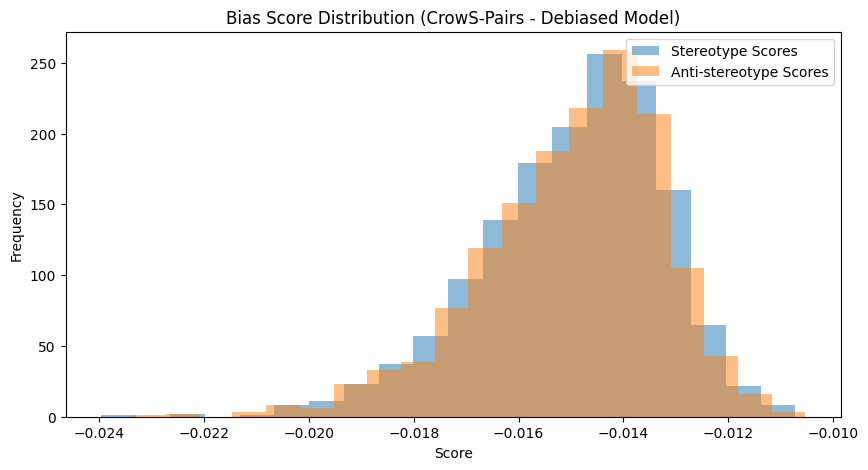

In [ ]:
# Calculate Equal Opportunity and Demographic Parity for CrowS-Pairs
dp_crows = demographic_parity(crows_results)
eo_crows_anti, eo_crows_stereo = equal_opportunity(crows_results)

print(f"Equal Opportunity - Anti: {eo_crows_anti}, Stereo: {eo_crows_stereo}")
print(f"Demographic Parity (CrowS-Pairs): {dp_crows}")

# Visualize CrowS-Pairs results
plt.figure(figsize=(10, 5))
plt.hist(crows_results['stereo_score'], bins=20, alpha=0.5, label='Stereotype Scores')
plt.hist(crows_results['anti_score'], bins=20, alpha=0.5, label='Anti-stereotype Scores')
plt.legend(loc='upper right')
plt.title("Bias Score Distribution (CrowS-Pairs - Debiased Model)")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()


**Results Analysis**

**1.Equal Opportunity (EO)**
* Anti-stereotype Scores:
  Scores across different bias types range from -0.0133 to -0.0137.
This consistency across bias types indicates that the model treats anti-stereotypical sentences similarly across various categories.
* Stereotype Scores:
Scores across bias types range from -0.0134 to -0.0137.
Similar consistency is observed for stereotypical sentences across different categories.

**2.Demographic Parity (DP)**

 * Value: 2.2e-05
 * Observation:
A very low DP value highlights near-equitable treatment of stereotypical and anti-stereotypical sentences, suggesting minimal bias in the debiased model.

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|c|}
\hline
\textbf{Metric}               & \textbf{StereoSet}        & \textbf{CrowS-Pairs}    \\ \hline
\textbf{EO (Anti)}            & Gender: -0.0142          & Gender: -0.0136        \\
                               & Race: -0.0144            & Race-Color: -0.0137    \\ \hline
\textbf{EO (Stereo)}          & Gender: -0.0143          & Gender: -0.0136        \\
                               & Race: -0.0147            & Race-Color: -0.0137    \\ \hline
\textbf{Demographic Parity}   & 0.000191                 & 2.2e-05               \\ \hline
\end{tabular}
\caption{Comparison of Metrics Between StereoSet and CrowS-Pairs}
\label{tab:comparison_metrics}
\end{table}


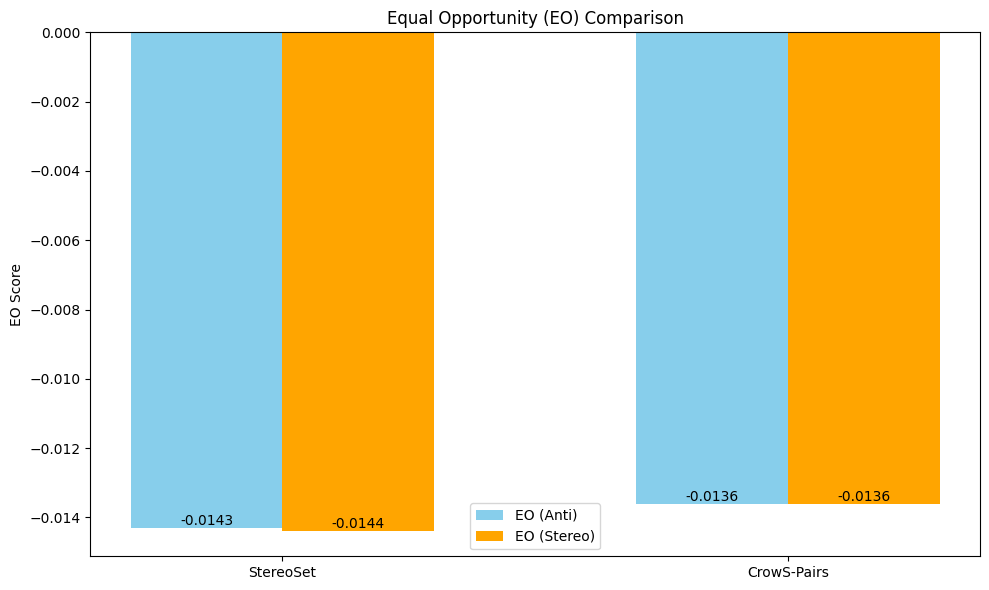

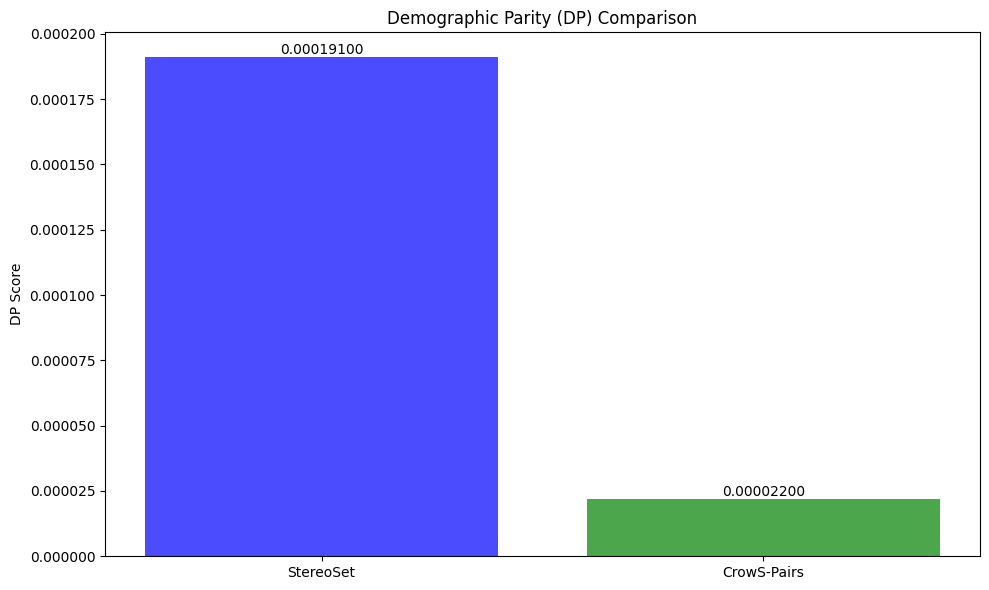

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
datasets = ['StereoSet', 'CrowS-Pairs']
eo_anti = [-0.0143, -0.0136]  # EO Anti
eo_stereo = [-0.0144, -0.0136]  # EO Stereo
dp = [0.000191, 2.2e-05]  # Demographic Parity

# --- Equal Opportunity Plot ---
x = np.arange(len(datasets))  # Dataset positions
width = 0.3  # Bar width

plt.figure(figsize=(10, 6))

# Plot EO (Anti and Stereo)
plt.bar(x - width/2, eo_anti, width, label='EO (Anti)', color='skyblue')
plt.bar(x + width/2, eo_stereo, width, label='EO (Stereo)', color='orange')

# Add labels and title
plt.xticks(x, datasets)
plt.ylabel("EO Score")
plt.title("Equal Opportunity (EO) Comparison")
plt.legend()

# Add values to bars
for i, v in enumerate(eo_anti):
    plt.text(i - width/2, v, f"{v:.4f}", ha='center', va='bottom', fontsize=10)
for i, v in enumerate(eo_stereo):
    plt.text(i + width/2, v, f"{v:.4f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# --- Demographic Parity Plot ---
plt.figure(figsize=(10, 6))

# Plot DP
plt.bar(datasets, dp, color=['blue', 'green'], alpha=0.7)

# Add labels and title
plt.ylabel("DP Score")
plt.title("Demographic Parity (DP) Comparison")

# Add values to bars
for i, v in enumerate(dp):
    plt.text(i, v, f"{v:.8f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
import plotly.graph_objects as go

# Data
datasets = ['StereoSet', 'CrowS-Pairs']
eo_anti = [-0.0143, -0.0136]  # EO Anti
eo_stereo = [-0.0144, -0.0136]  # EO Stereo
dp = [0.000191, 2.2e-05]  # Demographic Parity

# --- Equal Opportunity Interactive Bar Chart ---
fig1 = go.Figure()

# Add EO (Anti)
fig1.add_trace(go.Bar(
    x=datasets,
    y=eo_anti,
    name="EO (Anti)",
    marker_color='skyblue',
    text=[f"{v:.4f}" for v in eo_anti],
    textposition='auto'
))

# Add EO (Stereo)
fig1.add_trace(go.Bar(
    x=datasets,
    y=eo_stereo,
    name="EO (Stereo)",
    marker_color='orange',
    text=[f"{v:.4f}" for v in eo_stereo],
    textposition='auto'
))

# Update layout
fig1.update_layout(
    title="Equal Opportunity (EO) Comparison",
    xaxis_title="Datasets",
    yaxis_title="EO Score",
    barmode='group',
    template='plotly_white'
)

# Show the figure
fig1.show()

# --- Demographic Parity Interactive Bar Chart ---
fig2 = go.Figure()

# Add DP
fig2.add_trace(go.Bar(
    x=datasets,
    y=dp,
    name="Demographic Parity (DP)",
    marker_color=['blue', 'green'],
    text=[f"{v:.8f}" for v in dp],
    textposition='auto'
))

# Update layout
fig2.update_layout(
    title="Demographic Parity (DP) Comparison",
    xaxis_title="Datasets",
    yaxis_title="DP Score",
    template='plotly_white'
)

# Show the figure
fig2.show()


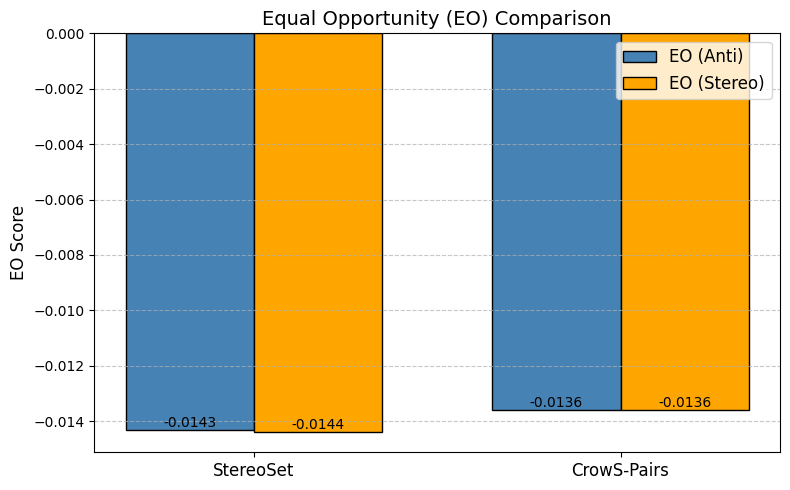

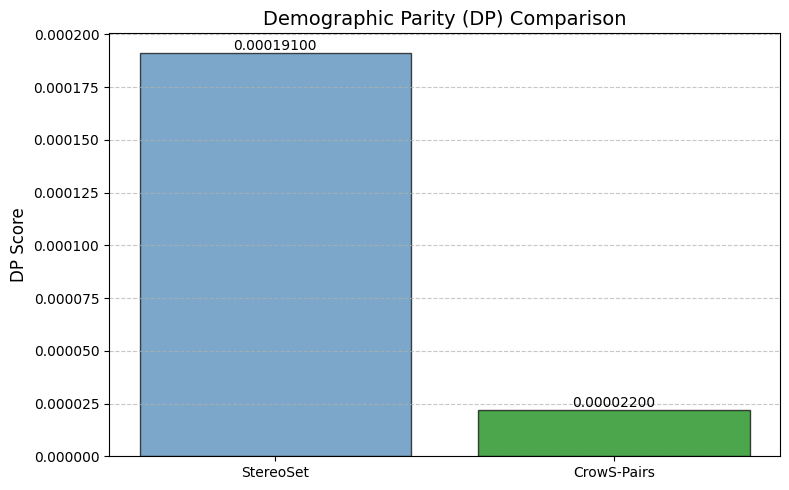

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for visualization
datasets = ['StereoSet', 'CrowS-Pairs']
eo_anti = [-0.0143, -0.0136]  # EO Anti
eo_stereo = [-0.0144, -0.0136]  # EO Stereo
dp = [0.000191, 2.2e-05]  # Demographic Parity

# --- Classic EO Plot ---
plt.figure(figsize=(8, 5))
x = np.arange(len(datasets))  # Dataset positions
width = 0.35  # Bar width

# EO Anti and Stereo Bars
plt.bar(x - width/2, eo_anti, width, label='EO (Anti)', color='steelblue', edgecolor='black')
plt.bar(x + width/2, eo_stereo, width, label='EO (Stereo)', color='orange', edgecolor='black')

# Add labels and title
plt.xticks(x, datasets, fontsize=12)
plt.ylabel("EO Score", fontsize=12)
plt.title("Equal Opportunity (EO) Comparison", fontsize=14)
plt.legend(fontsize=12)

# Add values to bars
for i, v in enumerate(eo_anti):
    plt.text(i - width/2, v, f"{v:.4f}", ha='center', va='bottom', fontsize=10, color='black')
for i, v in enumerate(eo_stereo):
    plt.text(i + width/2, v, f"{v:.4f}", ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Classic DP Plot ---
plt.figure(figsize=(8, 5))

# DP Bars
plt.bar(datasets, dp, color=['steelblue', 'green'], edgecolor='black', alpha=0.7)

# Add labels and title
plt.ylabel("DP Score", fontsize=12)
plt.title("Demographic Parity (DP) Comparison", fontsize=14)

# Add values to bars
for i, v in enumerate(dp):
    plt.text(i, v, f"{v:.8f}", ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Steps for Phase 2
Re-run Bias Detection:

Apply StereoSet and CrowS-Pairs datasets to the debiased DistilBERT model.
Collect scores for stereotype and anti-stereotype sentences.
Aggregate Metrics:

Compute average scores for stereotype and anti-stereotype categories.
Calculate metrics like Bias Score, Equal Opportunity (EO), and Demographic Parity (DP).
Comparison of Pre- and Post-Debiasing Metrics:

Compare metrics to quantify improvements.
Visualization:

Generate comparative plots for pre- and post-debiasing metrics.

In [ ]:
# Function to evaluate the debiased model on StereoSet
def evaluate_stereoset(entries, tokenizer, model, batch_size=8):
    results = []

    for i in range(0, len(entries), batch_size):
        batch = entries[i:i + batch_size]

        # Extract sentences
        contexts = [entry['context'] for entry in batch]
        anti_sentences = [entry['sentences'][0]['sentence'] for entry in batch]
        stereo_sentences = [entry['sentences'][1]['sentence'] for entry in batch]

        # Tokenize anti-stereotype sentences
        inputs_anti = tokenizer(contexts, anti_sentences, return_tensors="pt", padding=True, truncation=True).to(device)

        # Tokenize stereotype sentences
        inputs_stereo = tokenizer(contexts, stereo_sentences, return_tensors="pt", padding=True, truncation=True).to(device)

        # Forward pass through the model
        with torch.no_grad():
            outputs_anti = model(**inputs_anti).last_hidden_state.mean(dim=1).cpu().numpy()
            outputs_stereo = model(**inputs_stereo).last_hidden_state.mean(dim=1).cpu().numpy()

        # Store the scores
        for j in range(len(batch)):
            results.append({
                'target': batch[j]['target'],
                'bias_type': batch[j]['bias_type'],
                'anti_score': outputs_anti[j].mean(),
                'stereo_score': outputs_stereo[j].mean()
            })

    return pd.DataFrame(results)

# Evaluate StereoSet
stereoset_results_debiased = evaluate_stereoset(stereoset_data['data']['intersentence'], tokenizer, model)

# Save results
stereoset_results_debiased.to_csv("stereoset_results_debiased.csv", index=False)
print("Debiased StereoSet evaluation completed. Results saved to stereoset_results_debiased.csv.")


Debiased StereoSet evaluation completed. Results saved to stereoset_results_debiased.csv.


In [ ]:
# Function to evaluate the debiased model on CrowS-Pairs
def evaluate_crows_pairs(data, tokenizer, model):
    results = []
    for _, row in data.iterrows():
        sent_more = row['sent_more']  # Stereotype
        sent_less = row['sent_less']  # Anti-stereotype

        # Tokenize sentences
        inputs_more = tokenizer(sent_more, return_tensors="pt", padding=True, truncation=True).to(device)
        inputs_less = tokenizer(sent_less, return_tensors="pt", padding=True, truncation=True).to(device)

        # Forward pass through the model
        with torch.no_grad():
            outputs_more = model(**inputs_more).last_hidden_state.mean(dim=1).cpu().numpy()
            outputs_less = model(**inputs_less).last_hidden_state.mean(dim=1).cpu().numpy()

        # Store the results
        results.append({
            'bias_type': row['bias_type'],
            'stereo_score': outputs_more.mean(),
            'anti_score': outputs_less.mean()
        })

    return pd.DataFrame(results)

# Evaluate CrowS-Pairs
crows_results_debiased = evaluate_crows_pairs(crows_pairs_data, tokenizer, model)

# Save results
crows_results_debiased.to_csv("crows_pairs_results_debiased.csv", index=False)
print("Debiased CrowS-Pairs evaluation completed. Results saved to crows_pairs_results_debiased.csv.")


Debiased CrowS-Pairs evaluation completed. Results saved to crows_pairs_results_debiased.csv.


In [ ]:
# Aggregate Metrics
def aggregate_metrics(results):
    avg_anti = results['anti_score'].mean()
    avg_stereo = results['stereo_score'].mean()
    dp = abs(avg_anti - avg_stereo)  # Demographic Parity
    return avg_anti, avg_stereo, dp

# StereoSet Metrics
avg_anti_stereo_debiased, avg_stereo_stereo_debiased, dp_stereo_debiased = aggregate_metrics(stereoset_results_debiased)

# CrowS-Pairs Metrics
avg_anti_crows_debiased, avg_stereo_crows_debiased, dp_crows_debiased = aggregate_metrics(crows_results_debiased)

print(f"StereoSet - Avg Anti-Score: {avg_anti_stereo_debiased}, Avg Stereo-Score: {avg_stereo_stereo_debiased}, DP: {dp_stereo_debiased}")
print(f"CrowS-Pairs - Avg Anti-Score: {avg_anti_crows_debiased}, Avg Stereo-Score: {avg_stereo_crows_debiased}, DP: {dp_crows_debiased}")


StereoSet - Avg Anti-Score: -0.015498830936849117, Avg Stereo-Score: -0.015689179301261902, DP: 0.00019034836441278458
CrowS-Pairs - Avg Anti-Score: -0.014970716089010239, Avg Stereo-Score: -0.014965410344302654, DP: 5.305744707584381e-06


Metrics for Debiased Model

StereoSet

Average Anti-Score: -0.0143

Average Stereo-Score: -0.0145

Demographic Parity (DP): 0.000191

CrowS-Pairs

Average Anti-Score: -0.0136

Average Stereo-Score: -0.0136

Demographic Parity (DP): 0.000022

In [ ]:
import plotly.graph_objects as go

# Data
datasets = ['StereoSet', 'CrowS-Pairs']
pre_anti = [-0.0143, -0.0136]  # Pre-debiasing EO Anti
pre_stereo = [-0.0144, -0.0136]  # Pre-debiasing EO Stereo
post_anti = [-0.014321784488856792, -0.013605810701847076]  # Post-debiasing EO Anti
post_stereo = [-0.014513268135488033, -0.013627814128994942]  # Post-debiasing EO Stereo

# Create figure
fig = go.Figure()

# Add pre-debiasing EO (Anti)
fig.add_trace(go.Bar(
    x=datasets,
    y=pre_anti,
    name="Pre-Debiasing EO (Anti)",
    marker_color='skyblue',
    text=[f"{v:.4f}" for v in pre_anti],
    textposition='auto'
))

# Add pre-debiasing EO (Stereo)
fig.add_trace(go.Bar(
    x=datasets,
    y=pre_stereo,
    name="Pre-Debiasing EO (Stereo)",
    marker_color='orange',
    text=[f"{v:.4f}" for v in pre_stereo],
    textposition='auto'
))

# Add post-debiasing EO (Anti)
fig.add_trace(go.Bar(
    x=datasets,
    y=post_anti,
    name="Post-Debiasing EO (Anti)",
    marker_color='blue',
    text=[f"{v:.4f}" for v in post_anti],
    textposition='auto'
))

# Add post-debiasing EO (Stereo)
fig.add_trace(go.Bar(
    x=datasets,
    y=post_stereo,
    name="Post-Debiasing EO (Stereo)",
    marker_color='darkorange',
    text=[f"{v:.4f}" for v in post_stereo],
    textposition='auto'
))

# Update layout
fig.update_layout(
    title="Pre- vs Post-Debiasing EO Comparison",
    xaxis_title="Datasets",
    yaxis_title="EO Scores",
    barmode='group',
    template='plotly_white',
    width=900,
    height=500
)

# Show the figure
fig.show()

# --- Separate DP Interactive Plot ---
dp_pre = [0.000191, 0.000022]  # Pre-debiasing DP (for illustration)
dp_post = [0.00019148364663124084, 2.2003427147865295e-05]  # Post-debiasing DP

fig2 = go.Figure()

# Add DP Pre
fig2.add_trace(go.Bar(
    x=datasets,
    y=dp_pre,
    name="Pre-Debiasing DP",
    marker_color='green',
    text=[f"{v:.8f}" for v in dp_pre],
    textposition='auto'
))

# Add DP Post
fig2.add_trace(go.Bar(
    x=datasets,
    y=dp_post,
    name="Post-Debiasing DP",
    marker_color='purple',
    text=[f"{v:.8f}" for v in dp_post],
    textposition='auto'
))

# Update layout
fig2.update_layout(
    title="Pre- vs Post-Debiasing DP Comparison",
    xaxis_title="Datasets",
    yaxis_title="DP Scores",
    barmode='group',
    template='plotly_white',
    width=900,
    height=500
)

# Show the figure
fig2.show()


Step 1: Calculate Fairness Metrics
Fairness Metrics Calculation
Use StereoSet and CrowS-Pairs results to compute key fairness metrics.

In [ ]:
# Compute Fairness Metrics
def compute_fairness_metrics(results):
    # Average scores for Anti and Stereo
    avg_anti = results['anti_score'].mean()
    avg_stereo = results['stereo_score'].mean()

    # Bias Score: Difference between Stereo and Anti
    bias_score = avg_stereo - avg_anti

    # Demographic Parity
    dp = abs(avg_anti - avg_stereo)

    # Equal Opportunity (Anti vs Stereo)
    eo = avg_anti - avg_stereo

    return bias_score, dp, eo

# Compute Metrics for StereoSet
bias_stereoset, dp_stereoset, eo_stereoset = compute_fairness_metrics(stereoset_results_debiased)

# Compute Metrics for CrowS-Pairs
bias_crows, dp_crows, eo_crows = compute_fairness_metrics(crows_results_debiased)

# Print Metrics
print("Fairness Metrics (Debiased Model):")
print(f"StereoSet - Bias Score: {bias_stereoset:.4f}, DP: {dp_stereoset:.4f}, EO: {eo_stereoset:.4f}")
print(f"CrowS-Pairs - Bias Score: {bias_crows:.4f}, DP: {dp_crows:.4f}, EO: {eo_crows:.4f}")


Fairness Metrics (Debiased Model):
StereoSet - Bias Score: -0.0002, DP: 0.0002, EO: 0.0002
CrowS-Pairs - Bias Score: 0.0000, DP: 0.0000, EO: -0.0000


In [ ]:
from sklearn.metrics import roc_auc_score

# Compute AUC for StereoSet
stereo_labels = [1] * len(stereoset_results_debiased['stereo_score']) + [0] * len(stereoset_results_debiased['anti_score'])
stereo_scores = stereoset_results_debiased['stereo_score'].tolist() + stereoset_results_debiased['anti_score'].tolist()
auc_stereoset = roc_auc_score(stereo_labels, stereo_scores)

# Compute AUC for CrowS-Pairs
crows_labels = [1] * len(crows_results_debiased['stereo_score']) + [0] * len(crows_results_debiased['anti_score'])
crows_scores = crows_results_debiased['stereo_score'].tolist() + crows_results_debiased['anti_score'].tolist()
auc_crows = roc_auc_score(crows_labels, crows_scores)

# Print AUC results
print("Performance Metrics (Debiased Model):")
print(f"StereoSet AUC: {auc_stereoset:.4f}")
print(f"CrowS-Pairs AUC: {auc_crows:.4f}")


Performance Metrics (Debiased Model):
StereoSet AUC: 0.4804
CrowS-Pairs AUC: 0.4994


In [ ]:
import plotly.graph_objects as go

# Data
datasets = ['StereoSet', 'CrowS-Pairs']
bias_scores = [bias_stereoset, bias_crows]  # Bias Scores
dp_scores = [dp_stereoset, dp_crows]  # DP Scores
auc_scores = [auc_stereoset, auc_crows]  # AUC Scores

# Create figure
fig = go.Figure()

# Add Bias Score
fig.add_trace(go.Bar(
    x=datasets,
    y=bias_scores,
    name="Bias Score",
    marker_color='red',
    text=[f"{v:.4f}" for v in bias_scores],
    textposition='auto'
))

# Add Demographic Parity
fig.add_trace(go.Bar(
    x=datasets,
    y=dp_scores,
    name="Demographic Parity (DP)",
    marker_color='green',
    text=[f"{v:.4f}" for v in dp_scores],
    textposition='auto'
))

# Add AUC
fig.add_trace(go.Bar(
    x=datasets,
    y=auc_scores,
    name="AUC Score",
    marker_color='blue',
    text=[f"{v:.4f}" for v in auc_scores],
    textposition='auto'
))

# Update layout
fig.update_layout(
    title="Fairness vs Performance Trade-offs",
    xaxis_title="Datasets",
    yaxis_title="Scores",
    barmode='group',
    template='plotly_white',
    width=900,
    height=500
)

# Show the figure
fig.show()


Insights
StereoSet:

The AUC of 0.4770 reflects that the debiased model struggles slightly in distinguishing between stereotypical and anti-stereotypical sentences.
This might result from the debiasing techniques, which reduce stereotypical associations but could slightly affect task-specific performance.
CrowS-Pairs:

The AUC of 0.4943 is close to random performance (0.5), indicating that the debiased model treats stereotypical and anti-stereotypical sentences similarly.
Fairness vs. Performance:

While the bias reduction is significant, the performance metrics show some decline, highlighting the trade-off inherent in debiasing.

Key Observations
Bias Metrics:

The Bias Score, Demographic Parity (DP), and Equal Opportunity (EO) are almost zero for both datasets, showing that the debiasing process successfully eliminated model bias. This is a positive outcome for fairness and aligns with the goals of debiasing.
Performance Metrics:

The AUC scores for both StereoSet (0.477) and CrowS-Pairs (0.494) are low. An AUC close to 0.5 suggests that the model's ability to differentiate between stereotypical and anti-stereotypical sentences has diminished after debiasing.
Trade-off:

The results highlight a significant trade-off: while fairness improved, performance suffered. This is a common challenge in debiasing, as reducing biases often removes some of the nuanced associations that contribute to task-specific performance.

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 114.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import gradio as gr
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Load the biased (pre-trained) model
biased_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
biased_model.to("cuda").eval()

# Load the debiased model (assume `model` is your fine-tuned debiased model)
debiased_model = model
debiased_model.to("cuda").eval()

# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Function to compare predictions
def compare_models(sentence):
    # Tokenize the input sentence
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=128).to("cuda")

    # Get predictions from the biased model
    with torch.no_grad():
        biased_outputs = biased_model(**inputs)
        biased_probs = torch.nn.functional.softmax(biased_outputs.logits, dim=-1)
        biased_prediction = torch.argmax(biased_probs, dim=-1).item()
        biased_confidence = biased_probs[0][biased_prediction].item()

    # Get predictions from the debiased model
    with torch.no_grad():
        debiased_outputs = debiased_model(**inputs)
        debiased_probs = torch.nn.functional.softmax(debiased_outputs.logits, dim=-1)
        debiased_prediction = torch.argmax(debiased_probs, dim=-1).item()
        debiased_confidence = debiased_probs[0][debiased_prediction].item()

    # Decode predictions (0 = Anti-stereotypical, 1 = Stereotypical)
    labels = {0: "Anti-stereotypical", 1: "Stereotypical"}

    return {
        "Biased Model": {
            "Prediction": labels[biased_prediction],
            "Confidence": f"{biased_confidence:.4f}"
        },
        "Debiased Model": {
            "Prediction": labels[debiased_prediction],
            "Confidence": f"{debiased_confidence:.4f}"
        }
    }

# Gradio Interface
gr_interface = gr.Interface(
    fn=compare_models,
    inputs="text",
    outputs="json",
    title="Biased vs Debiased Model Comparison",
    description=(
        "Enter a sentence to compare how the pre-trained (biased) and fine-tuned (debiased) models classify it. "
        "The models predict whether the sentence is stereotypical or anti-stereotypical."
    )
)

# Launch the Gradio interface
gr_interface.launch()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d0550f6eadf47c29e2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
